In [3]:
# imports for analysis
import numpy as np
from collections import defaultdict
from scipy.io import loadmat
from sklearn.metrics import adjusted_mutual_info_score
from joblib import Parallel, delayed

# imports for visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# imports for data loading, processing and analysis
from utils.io import get_args
import nibabel
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting, surface, datasets


/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [4]:
NTPS_FIR = 31 # how many timepoints investigated using FIR
args = get_args()
ridx, cidx = np.tril_indices(args.nROI, -1)
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:olive','tab:cyan']

In [5]:
def get_plot_line(a):
    """
    Takes in 2D array of shape [subjects,time points].
    Returns mean, and upper/lower SEM lines.
    """
    mean = np.nanmean(a,0)
    std = np.std(a,0)
    upper,lower = mean + std, mean - std
    return mean, upper, lower

In [6]:
def get_cluster_sizes(yhat):
    clusters = sorted(np.unique(yhat))

    cluster_sizes = np.full(len(clusters), np.nan)
    for cluster in clusters:
        cluster_sizes[cluster] = np.sum(yhat == cluster)
    return cluster_sizes

# ROI Visualizations

In [7]:
clusters_run1 = np.load('results/betas/clustered_rois_run1.npy')
cluster_sizes = get_cluster_sizes(clusters_run1)

In [8]:
cluster_cid_map ={}
for cid, cluster in enumerate(np.argsort(cluster_sizes)):
    cid = 9-cid #
    cluster_cid_map[cluster] = cid

# Visualize on projected surface, compare networks

In [9]:
fsaverage = datasets.fetch_surf_fsaverage("fsaverage")

def vol_to_surf_to_map(img, **plotting_kwargs):
    

    _, axes = plt.subplots(2,2, subplot_kw={'projection': '3d'})
    for j, side in enumerate(['left', 'right']):
        bg_map = surface.load_surf_data(fsaverage[f"sulc_{side}"])
        for i, view in enumerate(['lateral', 'medial']):

            surf_data = surface.vol_to_surf(img,
                surf_mesh=fsaverage[f"pial_{side}"],
                inner_mesh=fsaverage[f"white_{side}"],
                interpolation='nearest'
            )

            _ = plotting.plot_surf_stat_map(
                fsaverage[f'pial_{side}'],
                surf_data,
                hemi=side,
                bg_map=bg_map,
                view=view,
                colorbar=False,
                axes=axes[i,j],
                **plotting_kwargs
            )
    
    plt.tight_layout()
    plt.subplots_adjust(
        wspace=-.35,
        hspace=-.25)
    plt.savefig('results/figures/HRF_roi_clusters_surface_projected.png', bbox_inches="tight", dpi=400, transparent=True)
    plt.show()
    plt.close()

In [10]:
new_yhat = [cluster_cid_map[c] for c in clusters_run1]  # remapped to match order/color of clusters in img

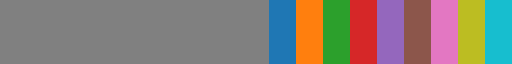

In [11]:
ncolors = len(colors)
expanded_colors = (['gray'] * (ncolors+1)) + colors
cmap = ListedColormap(expanded_colors)
cmap

In [12]:
roi_nums = new_yhat

shen_mask = NiftiLabelsMasker(args.atlas_loc)
_ = shen_mask.fit_transform(args.atlas_loc)
shen_img = nibabel.load(shen_mask.labels_img)
shen_data = shen_img.get_fdata()
for i in range(1, 269):
    shen_data[shen_data==i] = roi_nums[i-1]

updated_shen_img = nibabel.Nifti1Image(shen_data, shen_img.affine, shen_img.header)

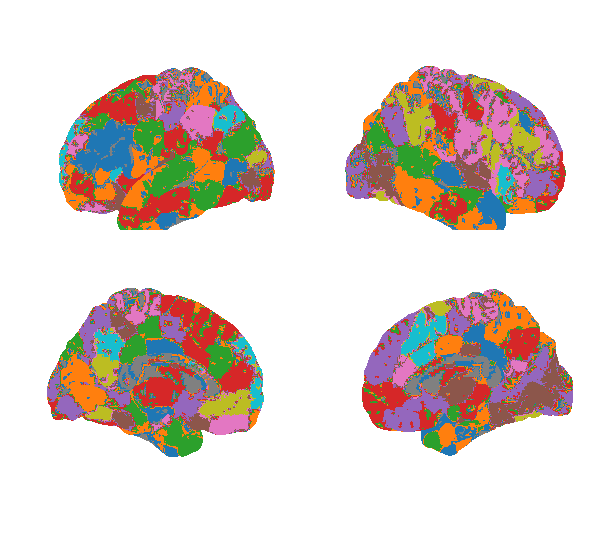

In [11]:
vol_to_surf_to_map(updated_shen_img, cmap=cmap)

## Test if the clusters are similar to the network definitions

In [13]:
shen_network_labels = loadmat('Shen_network_labels.mat')
network_mappings = shen_network_labels['Shen_network_labels'].flatten()
network_names = ['medialfrontal', 'frontalparietal', 'default', 'subcorticalcerebellar', 'motor', 'visual2', 'visual1', 'visualassociation']

In [18]:
def perm_test_ami_parallel(labels1, labels2, n_perm=10_000):
    ami = adjusted_mutual_info_score(labels1, labels2)

    permed_amis = Parallel(n_jobs=-1)(delayed(adjusted_mutual_info_score)(labels1, np.random.permutation(labels2)) for _ in range(n_perm))

    p = (np.sum(np.abs(permed_amis) >= ami)+1) / (n_perm+1)
    print(ami, p)

    _ = sns.histplot(permed_amis)
    plt.axvline(ami, color='red')
    plt.show()
    plt.close()

0.07963538929581816 9.999000099990002e-05


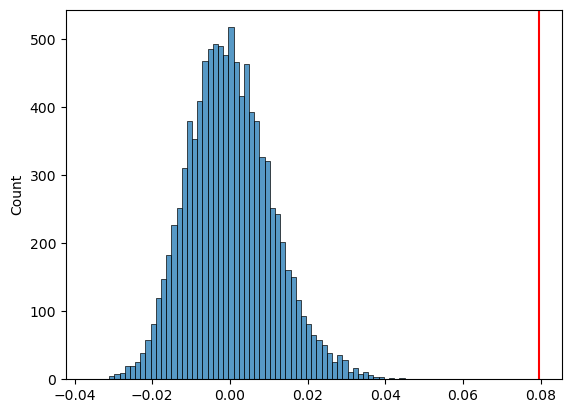

In [19]:
perm_test_ami_parallel(network_mappings, new_yhat)

## ROIs - Compare Run 2 to Run 1, network labels

In [20]:
clusters_run2 = np.load('results/betas/clustered_rois_run2.npy')

0.22318659643227384 9.999000099990002e-05


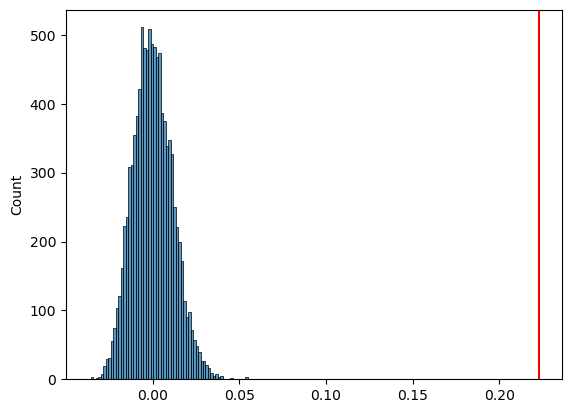

In [21]:
perm_test_ami_parallel(clusters_run1, clusters_run2)

0.07582895671160823 9.999000099990002e-05


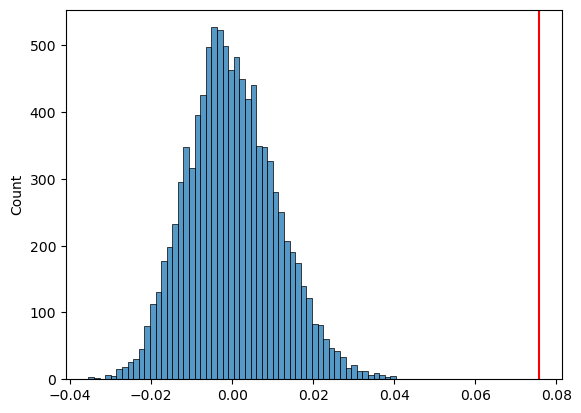

In [22]:
perm_test_ami_parallel(network_mappings, clusters_run2)

# Edge Visualizations

In [23]:
clusters_run1 = np.load('results/betas/clustered_edges_run1.npy')
cluster_sizes = get_cluster_sizes(clusters_run1)

In [24]:
new_yhat = [cluster_cid_map[c] for c in clusters_run1]  # remapped to match order/color of clusters in img

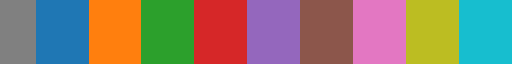

In [25]:
expanded_colors = [[c, c, c] for c in colors]
expanded_colors = [item for sublist in expanded_colors for item in sublist]
cmap = ListedColormap(['gray', 'gray'] + expanded_colors)
cmap

In [26]:
network_cluster_order = np.argsort(network_mappings)
ordered_networks = network_mappings[network_cluster_order]
print(ordered_networks) # proof that the sorting works

cutoffs = np.where(np.diff(network_mappings[network_cluster_order])!=0)[0] + 1 # shift to hit the gaps

label_locs = (np.concatenate([[0], cutoffs]) + np.concatenate([cutoffs, [268]])) / 2

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8]


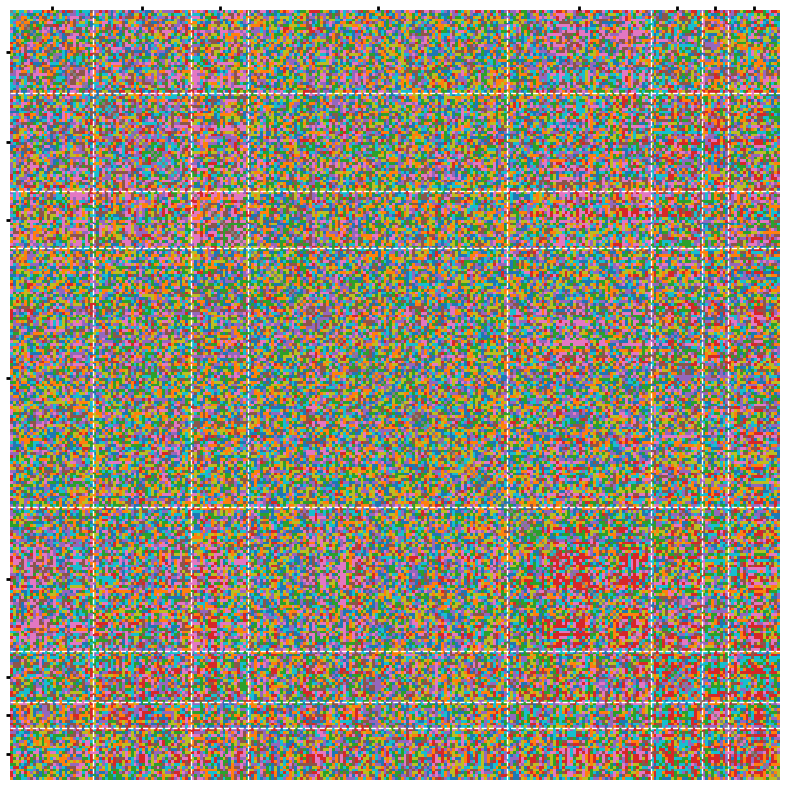

In [27]:
cluster_mat = np.zeros((args.nROI, args.nROI))
cluster_mat[ridx, cidx] = new_yhat
cluster_mat = cluster_mat + cluster_mat.T
cluster_mat = cluster_mat[np.ix_(network_cluster_order, network_cluster_order)]
plt.figure(figsize=(8,8))  
ax = sns.heatmap(cluster_mat,
                square=True,
                rasterized=True,
                cmap=cmap,
                cbar=False)
_ = ax.hlines(cutoffs, *ax.get_xlim(), color='white', linewidth=1, linestyle='dashed')
_ = ax.vlines(cutoffs, *ax.get_xlim(), color='white', linewidth=1, linestyle='dashed')

# clean up ticks to use with network labels
ax.set_aspect("equal")
ax.set_xticks(label_locs)
_ = ax.set_xticklabels([])
ax.xaxis.tick_top()
ax.set_yticks(label_locs)
_ = ax.set_yticklabels([])
ax.tick_params(width=2, length=3)

plt.tight_layout()
plt.savefig('results/figures/HRF_edge_clusters_matrix_vis.png', bbox_inches="tight", dpi=400, transparent=True)
plt.show()
plt.close()

In [28]:
np.unique(network_mappings)

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)

In [29]:
network_network_labels = []
for r,c in zip(ridx, cidx):
    net_r = network_mappings[r]
    net_c = network_mappings[c]
    if net_r <= net_c:
        network_network_labels.append(str(net_r)+'_'+str(net_c))
    else:
        network_network_labels.append(str(net_c)+'_'+str(net_r))

0.011851121327018132 9.999000099990002e-05


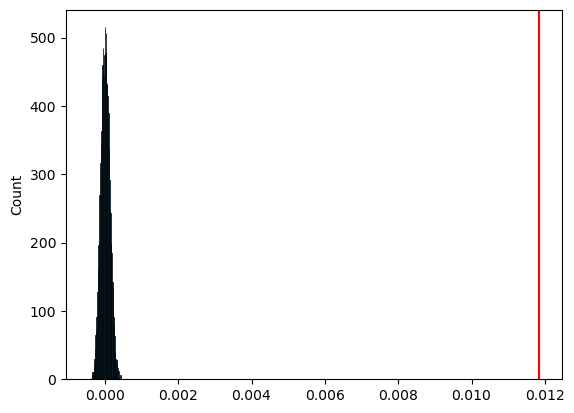

In [30]:
perm_test_ami_parallel(network_network_labels, new_yhat)

## Edges - compare run 2 to run 1, network-network labels

In [31]:
clusters_run2 = np.load('results/betas/clustered_edges_run2.npy')

0.004613769087670329 9.999000099990002e-05


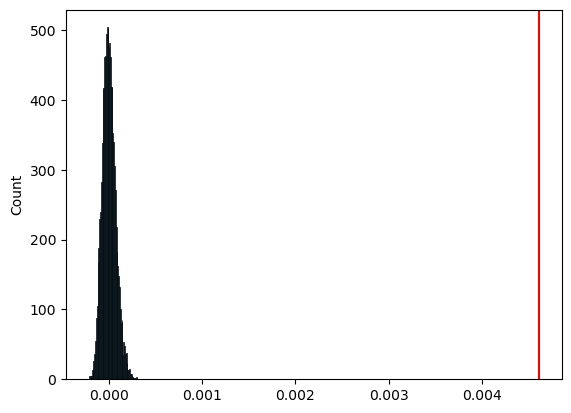

In [32]:
perm_test_ami_parallel(clusters_run1, clusters_run2)

0.009829741514610683 9.999000099990002e-05


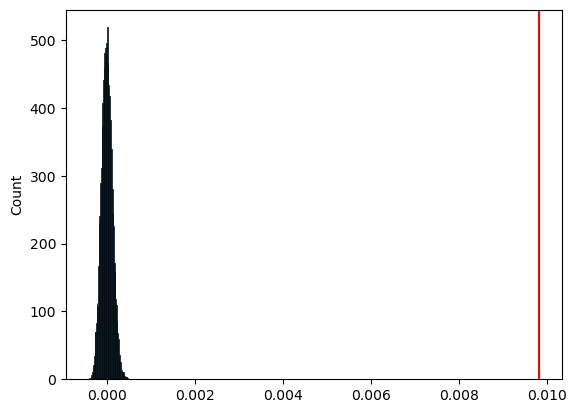

In [33]:
perm_test_ami_parallel(network_network_labels, clusters_run2)